In [1]:
import CodingQuiz1lib as given
import numpy as np
np.random.seed(5)
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import tqdm

[0.01404067 0.11816142 0.40426436 0.45028626 0.01324729]
[ 1465 11818 40808 44541  1368]


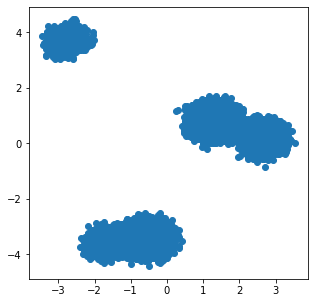

In [2]:
# CREATING THE TARGET DISTRIBUTION ACCORDING TO LIBRARY
ptarget = given.GMM()
samples = ptarget.sample(100000) # to obtain samples
given.plot_samples_2d(samples)

In [3]:
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
# device = 'cpu'
batch_size = 256
nz = 2
K = 1
epochs = 250
sample_size = 10000
train_data = torch.from_numpy(samples).to(device).float()

In [4]:
class Generator(nn.Module):
    def __init__(self, h_dim=64):
        super(Generator, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(2, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, 2),     
        )
    
    def forward(self, z):
        generated_samples = self.net(z)
        return generated_samples    

In [5]:
class Discriminator(nn.Module):
    def __init__(self, D=2, h_dim=128):
        super(Discriminator, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(D,h_dim),
            nn.BatchNorm1d(num_features=h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, h_dim),
            nn.BatchNorm1d(num_features=h_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(h_dim, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        output = self.net(x)
        return output.reshape(-1)

In [6]:
netG = Generator().to(device)
netD = Discriminator().to(device)

optim_G = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
optim_D = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))


criterion = nn.BCELoss()

netG.train()
netD.train()

netG_total_params = sum(p.numel() for p in netG.parameters())
netD_total_params = sum(p.numel() for p in netD.parameters())

print(netG)
print(netG_total_params)

print(netD)
print(netD_total_params)

Generator(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): LeakyReLU(negative_slope=0.2)
    (4): Linear(in_features=64, out_features=2, bias=True)
  )
)
4482
Discriminator(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2)
    (3): Linear(in_features=128, out_features=128, bias=True)
    (4): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2)
    (6): Linear(in_features=128, out_features=1, bias=True)
    (7): Sigmoid()
  )
)
17537


In [7]:
# to create real labels (1s)
def label_real(size):
    data = torch.ones(size)
    return data.to(device)

# to create fake labels (0s)
def label_fake(size):
    data = torch.zeros(size)
    return data.to(device)

# function to create the noise vector from standard normal distribution
def create_noise(sample_size=sample_size, nz=2):
    return torch.randn(sample_size, nz).to(device)

In [8]:
def train_discriminator(optimizer, data_real, data_fake):
    b_size = data_real.size(0)
    real_label = label_real(b_size)
    fake_label = label_fake(b_size)

    optimizer.zero_grad()

    output_real = netD(data_real)
    loss_real = criterion(output_real, real_label)

    output_fake = netD(data_fake)
    loss_fake = criterion(output_fake, fake_label)

    loss_real.backward()
    loss_fake.backward()
    optimizer.step()

    D_x = output_real.mean().item()
    D_G_z1 = output_fake.mean().item()

    return loss_real, loss_fake, D_x, D_G_z1

In [9]:
def train_generator(optimizer, data_fake):
    b_size = data_fake.size(0)
    real_label = label_real(b_size)

    optimizer.zero_grad()

    output = netD(data_fake)
    loss = criterion(output, real_label)

    loss.backward()
    optimizer.step()

    D_G_z2 = output.mean().item()

    return loss, D_G_z2

In [10]:
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)

In [11]:
noise = create_noise(sample_size, nz)

In [12]:
losses_g = []
losses_d = []
losses_d_real = []
losses_d_fake = []
losses_g_batch = []
images = []

In [13]:
for epoch in range(epochs):
    loss_g = 0.0
    loss_d = 0.0
    loss_d_real = 0.0
    loss_d_fake = 0.0
    for bi, data in enumerate(train_loader):
        data = data.to(device)
        b_size = len(data)
        # run the discriminator for k number of steps
        for step in range(K):
            data_fake = netG(create_noise(b_size, nz)).detach()
            data_real = data
            # train the discriminator network
            loss_d_r, loss_d_f, D_x, D_G_z1 = train_discriminator(optim_D, data_real, data_fake)
            loss_d_real += loss_d_r
            loss_d_fake += loss_d_f
            loss_d += (loss_d_r + loss_d_f)

        data_fake = netG(create_noise(b_size, nz))
        # train the generator network
        l_g, D_G_z2 = train_generator(optim_G, data_fake)
        losses_g_batch.append(l_g)
        loss_g += l_g
        
    # create the final fake image for the epoch
    generated_img = netG(noise).cpu().detach()
    images.append(generated_img)
    epoch_loss_g = loss_g / bi # total generator loss for the epoch
    epoch_loss_d = loss_d / bi*K # total discriminator loss for the epoch
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    losses_d_real.append(loss_d_real/bi*K)
    losses_d_fake.append(loss_d_fake/bi*K)
    
    print(f"Epoch {epoch} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}, D(x) / D(G(z)) : {D_x:.4f} / {D_G_z2:.4f}")

Epoch 0 of 250
Generator loss: 0.75153363, Discriminator loss: 1.27086926, D(x) / D(G(z)) : 0.5669 / 0.4432
Epoch 1 of 250
Generator loss: 1.09999263, Discriminator loss: 0.87343693, D(x) / D(G(z)) : 0.7348 / 0.2848
Epoch 2 of 250
Generator loss: 1.43884957, Discriminator loss: 0.63031977, D(x) / D(G(z)) : 0.7784 / 0.3119
Epoch 3 of 250
Generator loss: 1.32407451, Discriminator loss: 0.70482725, D(x) / D(G(z)) : 0.7481 / 0.3019
Epoch 4 of 250
Generator loss: 1.33266008, Discriminator loss: 0.75212348, D(x) / D(G(z)) : 0.6693 / 0.3273
Epoch 5 of 250
Generator loss: 1.22678852, Discriminator loss: 0.85778975, D(x) / D(G(z)) : 0.3331 / 0.4258
Epoch 6 of 250
Generator loss: 1.15800178, Discriminator loss: 0.88740975, D(x) / D(G(z)) : 0.7121 / 0.2760
Epoch 7 of 250
Generator loss: 1.16466260, Discriminator loss: 0.92125374, D(x) / D(G(z)) : 0.7461 / 0.3831
Epoch 8 of 250
Generator loss: 1.14135563, Discriminator loss: 0.93120962, D(x) / D(G(z)) : 0.6877 / 0.4027
Epoch 9 of 250
Generator los

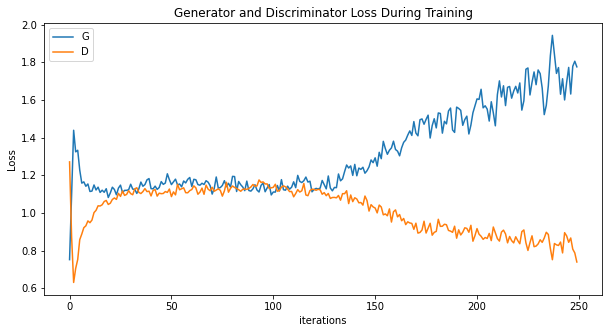

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(losses_g,label="G")
plt.plot(losses_d,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

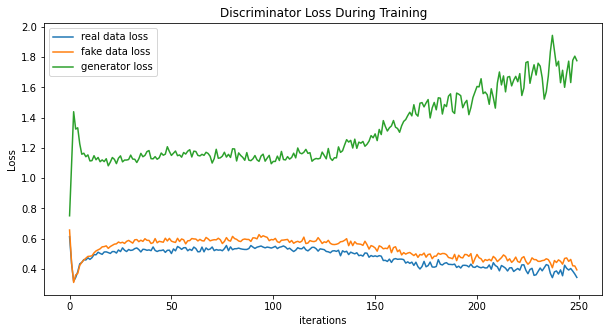

In [15]:
plt.figure(figsize=(10,5))
plt.title("Discriminator Loss During Training")
plt.plot(losses_d_real,label="real data loss")
plt.plot(losses_d_fake,label="fake data loss")
plt.plot(losses_g, label="generator loss")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

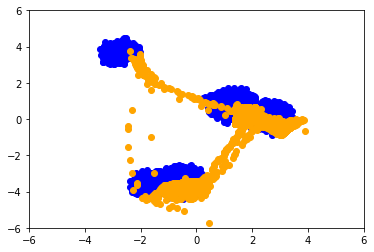

In [19]:
fig = plt.figure()
ax = plt.axes(xlim=(-6,6), ylim=(-6,6))
plt.scatter(samples[:,0], samples[:,1], c='blue')
plt.scatter(images[-1][:,0], images[-1][:,1], c='orange')

In [20]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython import display


In [21]:
z = create_noise(1000, 2)

In [22]:
def most_probable_component(x, p_star):
    p_i = []
    for i in range(len(p_star.weights)):
        p_i.append(p_star.components[i].prob(x))
    return p_i.index(max(p_i))

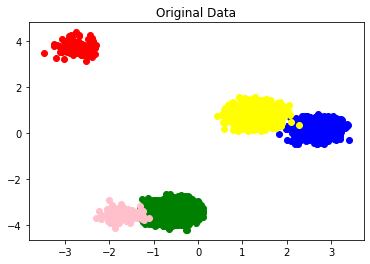

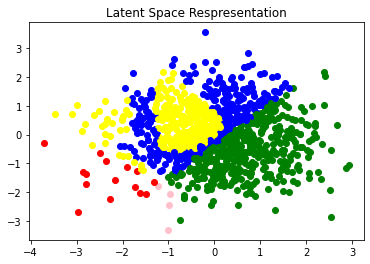

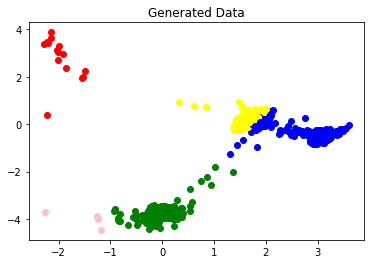

In [23]:
colors = ["red", "blue", "green", "yellow", "pink"]
plt.figure(0)
z_plot = z.cpu().detach().numpy()
for i in range(len(z)):
    x = netG(z[i].reshape(1,-1))
    x = x.cpu().detach().numpy()
    component = most_probable_component(x, ptarget)
    plt.figure(0)
    plt.scatter(z_plot[i][0], z_plot[i][1], c=colors[component])

    plt.figure(1)
    plt.scatter(x[0,0], x[0,1], c=colors[component])

plt.figure(2)
num = 10000
for i in range(5):
    n = int(ptarget.weights[i] * num)
    x = ptarget.components[i].sample(n)
    plt.scatter(x[:,0], x[:,1], c=colors[i])
plt.title("Original Data")



plt.figure(0)
plt.title("Latent Space Respresentation")

plt.figure(1)
plt.title("Generated Data")
plt.show()
    

In [21]:
for i in range(epochs):
    fig = plt.figure()
    ax = plt.axes(xlim=(-10,10), ylim=(-10,10))
    plt.scatter(samples[:,0], samples[:,1], c='blue')
    plt.scatter(images[i][:,0], images[i][:,1], c='orange')
    plt.title("Epoch " + str(i))
    plt.savefig('gan_training/epoch_' + str(i) + '.png')
    plt.close()
